# Data Prep

In this notebook I will import and inspect the image and telemetry data taken from Donkey Sim, and organize it for modeling steps.

* Import telemetry .csv
* Import image data
* Convert image data
* Create dataframe with: 
  * steering inputs, 
  * throttle inputs
  * converted imageds
* Save as a pickle format file for modeling

In [1]:
## Imports
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from tensorflow.keras.preprocessing.image import img_to_array, load_img

2021-11-17 11:36:59.480381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Telemetry Data

Steps:
* load simulation telemetry data csv
* cut unneeded columns
* cut incomplete last lap
* import images as numpy arrays
* create numpy array of image data arrays
* save images as input dataset X
* save steering angle and throttle data in numpy array as target dataset y


In [2]:
## Constants
working_date = '11_12_2021'
working_time = '19_28_18'
local_project_path = '/home/grant/projects/donkeysim-client/data'


# telemetry_columns = ['speed','pitch', 'yaw', 'roll', 'activeNode'] 
telemetry_columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 
               'gyro_z', 'vel_x', 'vel_y', 'vel_z',]

In [3]:
## Directories
local_data_directory = f'{local_project_path}/{working_date}/{working_time}'
local_image_directory = f'{local_data_directory}/images'
working_data_directory = f'../data/{working_date}/{working_time}'

## File paths
telemetry_csv = f'{local_data_directory}/data.csv'
input_image_dataset_file = f'{working_data_directory}/X_img.npy'
input_telem_dataset_file = f'{working_data_directory}/X_telem.pkl'
target_dataset_file = f'{working_data_directory}/y.npy'

In [4]:
## Make sure directoires exist
os.makedirs(working_data_directory, exist_ok=True)

### Load CSV file as DataFrame

In [5]:
df = pd.read_csv(telemetry_csv)
df.head()

,steering_angle,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,totalNodes,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,on_road,progress_on_shortest_path,lap
telemetry,0.0,0.016618,0.011107,2.62795.PNG,none,2.627950,-0.003734,0.114744,-0.343430,-0.000218,...,307,14.03957,0.563760,-68.18569,0.001070,-0.010486,0.003501,0,0,0
telemetry,0.0,0.054741,0.027851,2.678543.PNG,none,2.678543,-0.008975,0.123895,1.204847,0.000092,...,307,14.03902,0.563639,-68.18623,0.000550,-0.003081,0.027674,0,0,0
telemetry,0.0,0.094819,0.027349,2.727989.PNG,none,2.727989,-0.009076,0.117002,1.224393,0.000118,...,307,14.03850,0.563736,-68.18678,0.000188,0.001763,0.027292,0,0,0
telemetry,0.0,0.154448,0.035772,2.778249.PNG,none,2.778249,-0.008692,0.091593,0.638947,0.000203,...,307,14.03731,0.564071,-68.18811,-0.000317,0.007862,0.034896,0,0,0
telemetry,0.0,0.224829,0.054656,2.828085.PNG,none,2.828085,-0.001349,0.066614,0.582980,0.000339,...,307,14.03587,0.564352,-68.18963,-0.000429,0.010760,0.053585,0,0,0


### Rename Steering Column to Match Throttle

In [6]:
df.columns = ['steering' if col=='steering_angle' else col for col in df.columns]
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

In [7]:
## drop message label column
# df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125400 entries, telemetry to telemetry
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   steering                   125400 non-null  float64
 1   throttle                   125400 non-null  float64
 2   speed                      125400 non-null  float64
 3   image                      125400 non-null  object 
 4   hit                        125400 non-null  object 
 5   time                       125400 non-null  float64
 6   accel_x                    125400 non-null  float64
 7   accel_y                    125400 non-null  float64
 8   accel_z                    125400 non-null  float64
 9   gyro_x                     125400 non-null  float64
 10  gyro_y                     125400 non-null  float64
 11  gyro_z                     125400 non-null  float64
 12  gyro_w                     125400 non-null  float64
 13  pitch                  

In [9]:
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

### Pare Useless Columns

In [10]:
drop_columns = ['hit', 'time', 'gyro_w', 'pitch', 'yaw', 'roll', 
                'totalNodes', 'pos_x', 'pos_y', 'pos_z', 'on_road',
                'progress_on_shortest_path']

In [11]:
df['lap'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151])

In [12]:
sys.getsizeof(df)

50649068

In [13]:
df.dtypes

steering                     float64
throttle                     float64
speed                        float64
image                         object
hit                           object
time                         float64
accel_x                      float64
accel_y                      float64
accel_z                      float64
gyro_x                       float64
gyro_y                       float64
gyro_z                       float64
gyro_w                       float64
pitch                        float64
yaw                          float64
roll                         float64
cte                          float64
activeNode                     int64
totalNodes                     int64
pos_x                        float64
pos_y                        float64
pos_z                        float64
vel_x                        float64
vel_y                        float64
vel_z                        float64
on_road                        int64
progress_on_shortest_path      int64
l

### Convert datatypes (?)

In [14]:
for col in df.columns:
    if df[col].dtype == 'float':
        df[col] = pd.to_numeric(df[col], downcast='float')

In [15]:
sys.getsizeof(df)

40115468

### Remove "Extra" Laps

In [16]:
## Cut off the little bit after the end of the training session
df = df.loc[(df['lap'] > 0) & (df['lap'] < df['lap'].max()), :] #.drop(columns='lap')
df['lap'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

### Convert lap to category

In [17]:
df.loc[:, 'lap'] = df.loc[:, 'lap'].astype('category')

In [18]:
sys.getsizeof(df)

39329854

### Create lap time df

In [19]:
laps = pd.DataFrame(df.groupby(by='lap')['time'].describe()[['max', 'min']])
laps.head()

,max,min
lap,,
1,48.882130,4.478246
2,90.987473,48.931431
3,132.791306,91.038071
4,173.981293,132.841904
5,216.135895,174.031006


In [20]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    150.000000
mean      41.709079
std        1.468404
min       40.206055
25%       41.014893
50%       41.378601
75%       41.854782
max       48.190918
Name: lap_time, dtype: float64

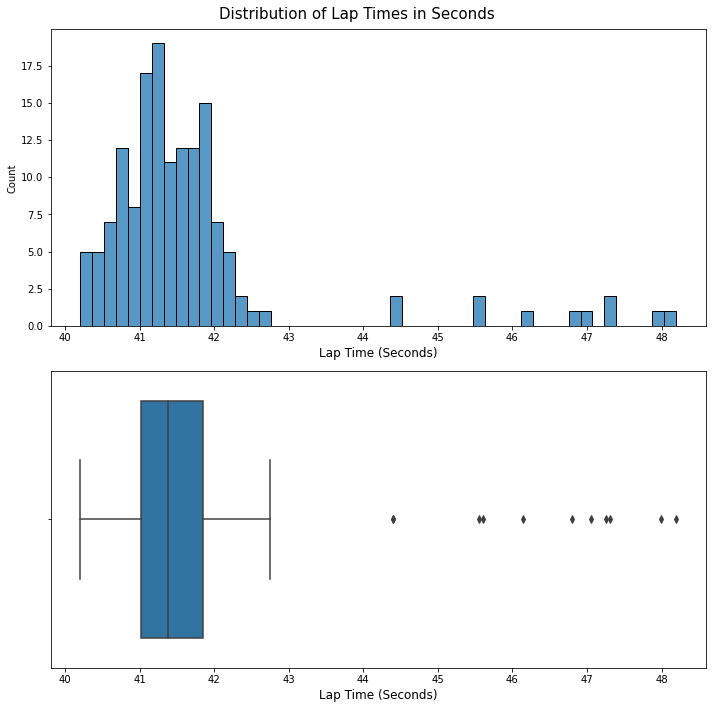

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [22]:
len(laps[laps['lap_time']>43])

11

### Add lap times to df to make sorting easier

In [23]:
df = pd.merge(left=df, right=laps['lap_time'], left_on='lap', right_index=True).copy()

### Cut laps longer than 43 seconds

In [24]:
df = df.loc[df['lap_time'] < 43, :].copy()
df.drop(columns=['lap', 'time'], inplace=True)
df.shape

(115052, 27)

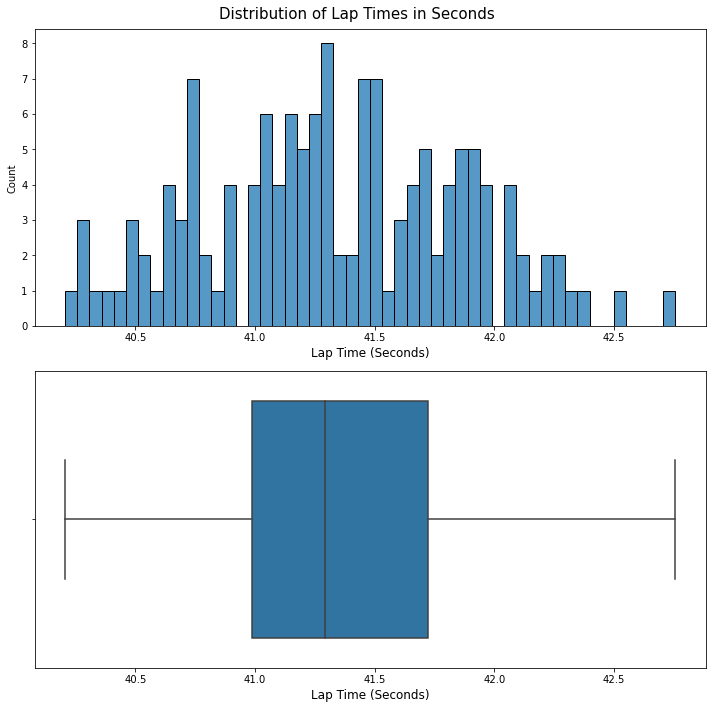

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps.loc[laps['lap_time'] < 43], bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps.loc[laps['lap_time'] < 43], ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [26]:
laps = laps.loc[laps['lap_time'] < 43]

In [27]:
laps['lap_time'].describe()

count    139.000000
mean      41.335628
std        0.536196
min       40.206055
25%       40.985352
50%       41.291016
75%       41.723145
max       42.755127
Name: lap_time, dtype: float64

*Try cutting anything lower than 42 then train again*

In [28]:
df = df.loc[df['lap_time'] < 42, :].copy()
df.drop(columns=['lap_time'], inplace=True)
df.shape

(102368, 26)

### After paring laps take telemetry data

### Save Telemetry Data

Doing so after cutting laps.

In [29]:
X_telem = df[telemetry_columns]
X_telem.describe()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,vel_x,vel_y,vel_z
count,102368.000000,102368.000000,102368.000000,102368.000000,102368.000000,1.023680e+05,102368.000000,102368.000000,102368.000000
mean,0.001435,-0.001101,-0.001413,0.000017,0.001520,-2.093377e-05,-0.359973,-0.124030,12.731518
std,2.697425,1.535470,3.965701,0.001362,0.005414,1.492871e-03,0.922008,0.271760,2.399441
min,-84.802498,-12.386760,-49.572800,-0.023662,-0.032501,-1.670798e-02,-8.900988,-1.339154,6.074970
25%,-1.223680,-0.964905,-2.443123,-0.000643,-0.000722,-7.206347e-04,-0.889829,-0.383769,10.832932
50%,0.019419,-0.053080,0.442290,0.000009,0.001529,-1.605889e-08,-0.284971,-0.028645,12.707540
75%,1.273894,0.882434,2.850235,0.000673,0.005762,6.942443e-04,0.039434,0.070044,14.260202
max,94.708817,53.589142,10.457180,0.013699,0.040941,3.330157e-02,5.964907,1.289006,18.467470


In [30]:
## Save as pickle
X_telem.to_pickle(input_telem_dataset_file)

## Image Data

In [31]:
df = df[['steering', 'throttle', 'image', ]]

### Verify Files

In [32]:
## Verify Files
os.listdir(local_image_directory)[:5]

['2777.586.PNG',
 '896.3273.PNG',
 '1769.436.PNG',
 '4331.179.PNG',
 '4090.235.PNG']

## Create Image Array

In [33]:
## Using keras, load images as list, adding to a list
img_array_list = []
for img in df['image']:
    img_array_list.append(img_to_array(load_img(f"{local_image_directory}/{img}", 
                                                color_mode='grayscale',))) 
                                                # target_size=(60, 80))))

In [34]:
## convert list of arrays into a numpy array (of arrays())
X_img = np.array(img_array_list)

### Scale Image Data

In [35]:
X_img /= 255

## Create Datasets

### Create Targets

In [36]:
## Target: throttle and steering data
y = df.loc[:, ['steering', 'throttle']].to_numpy().copy()

## Verify size
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

X.shape: (102368, 64, 64, 1)
y.shape: (102368, 2)


### Save Datasets

In [37]:
## Save as binary NumPy .npy format
with open(input_image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)